+ Requirements:
    1. The "tools_camera.py" file.
    2. The estimated time to carry out this activity is approximately half an hour.
<br><br>
+ Objectives of the notebook:
    1. Presentation of the Homography.
    2. Homography Calibration.
    3. 3D reconstruction with planar restriction.
<br><br>
+ Summary of activities:
    1. Code of the direct projection of a homography will be analyzed, implemented in Python with Numpy.
    2. A homography calibration code will be analyzed, implemented in Python with Numpy and with OpenCV functionality.
    3. Code that allows planar reconstruction will be analyzed.

# Introduction to Homography
The camera model is a transformation matrix $^{nd}\mathbf{T}_w$ that allows projecting a 3D point of the world $\mathbf{p}_w$ obtaining the pixel $\mathbf{p}_{nd} $ on the 2D image plane.

$$\begin{equation*} \mathbf{p}_{nd} = \, ^{nd}\mathbf{T}_w \cdot \mathbf{p}_w \end{equation*}$$

The homography $^{nd}\mathbf{H}_w$ is the projection matrix where the points of the world $\mathbf{p}_w$ are constrained to be coplanar.
If all points in the world are coplanar, we can define the world coordinate system in such a way that this world plane coincides with the XY plane of the world coordinate system. In this way, the coordinates ${Z}_w$ of all points in the world will be $0$.

$$\begin{bmatrix} s \, u \\ s \, v \\ s \end{bmatrix} = \begin{bmatrix} {m}_{11}&{m}_{12}&{m}_{13}&{m}_{14} \\ {m}_{21}&{m}_{22}&{m}_{23}&{m}_{24} \\ {m}_{31}&{m}_{32}&{m}_{33}&{m}_{34} \end{bmatrix} \cdot \begin{bmatrix} {X}_w \\ {Y}_w \\ 0 \\ 1 \end{bmatrix} $$

In this case, the projection matrix becomes a $3\times3$ matrix (instead of $3\times4$) since column 3 cancels out by being multiplied by $0$

$$\begin{bmatrix} s \, u \\ s \, v \\ s \end{bmatrix} = \begin{bmatrix} {m}_{11}&{m}_{12}&{m}_{14} \\ {m}_{21}&{m}_{22}&{m}_{24} \\ {m}_{31}&{m}_{33}&{m}_{34} \end{bmatrix} \cdot \begin{bmatrix} {X}_w \\ {Y}_w \\ 1 \end{bmatrix} $$

$$^{d}\mathbf{H}_w = \lambda \cdot \begin{bmatrix} {f}_u & 0 & {u}_0 \\ 0 & {f}_v & {v}_0 \\ 0 & 0 & 1 \end{bmatrix} \cdot \, \begin{bmatrix} {r}_{11}&{r}_{12}&{t}_x \\ {r}_{21}&{r}_{22}&{t}_y \\ {r}_{31}&{r}_{32}&{t}_z \end{bmatrix}$$

In [1]:
import numpy as np
import cv2
import os
from PIL import Image
from torchvision.transforms import transforms
from math import pi
import math
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, Image, display, HTML  # funcionalidad para mostrar imágenes en el cuaderno
import tools_camera as ca

In [2]:
"""Original world points on the XY plane"""
nPuntos = 4
amplitudX = 500
amplitudY = 500

x = (np.random.rand(1, nPuntos) - 0.5) * amplitudX
y = (np.random.rand(1, nPuntos) - 0.5) * amplitudY
X =  np.concatenate( (x,y,np.ones((1,nPuntos))), axis=0)

if nPuntos == 4:
    print('World points:')
    print(ca.ndtotext(X))

World points:
┌──────────────────────────────┐
 [-107.89 231.47  8.43   81.87] 
 [ -55.09 135.19 51.71 -236.18] 
 [   1.00   1.00  1.00    1.00] 
└──────────────────────────────┘


In [3]:
"""Default camera homography"""
cam = ca.Cam()
H = cam.get_Homografy_planeXY()
print('Homagrafy:')
print(ca.ndtotext(H))

Projection matrix:
┌─────────────────────────┐
 [1.58 -0.25 -0.25 350.00] 
 [0.00 -1.33  0.91 300.00] 
 [0.00 -0.00 -0.00   1.00] 
└─────────────────────────┘
Homagrafy:
┌───────────────────┐
 [1.58 -0.25 350.00] 
 [0.00 -1.33 300.00] 
 [0.00 -0.00   1.00] 
└───────────────────┘


Image points (in pixels):
┌─────────────────────────────┐
 [185.93 754.38 363.83 460.84] 
 [359.24 133.00 240.04 526.10] 
 [  1.00   1.00   1.00   1.00] 
└─────────────────────────────┘


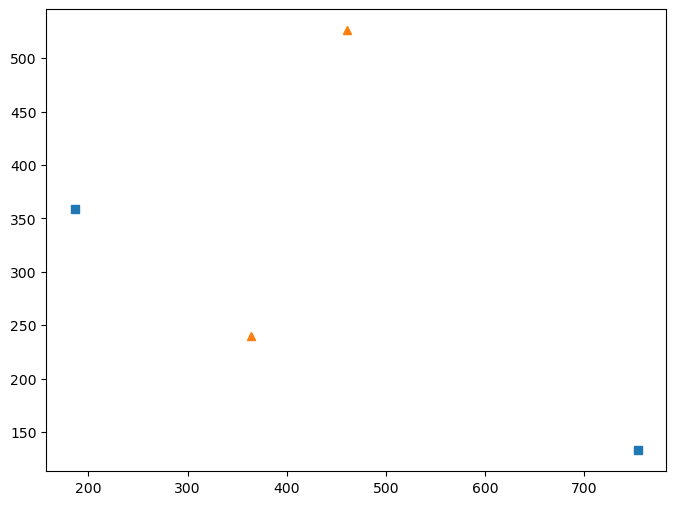

In [4]:
"""Image points (in pixeles)"""
U=cam.project(H,X)
if nPuntos == 4:
    print('Image points (in pixels):')
    print(ca.ndtotext(U))
cam.im_show(U)

# Calibrating a homography with Python

The calibration process consists of estimating the projection matrix $^{d}\mathbf{H}_w$ of a camera. We know that this matrix allows us to calculate the undistorted pixels of the image $\mathbf{p}_{d}$ from the world points $\mathbf{p}_w$ contained in a plane.

$$ \mathbf{p}_{d} = \begin{bmatrix} s \, u \\ s \, v \\ s \end{bmatrix} ;\:\:\:\: \mathbf{p}_{w} = \begin{bmatrix} {X}_w \\ {Y}_w \\ 1 \end{bmatrix} ;\:\:\:\: \mathbf{p}_{d} = \, ^{d}\mathbf{H}_w \cdot \mathbf{p}_w$$

$$\begin{bmatrix} s \, u \\ s \, v \\ s \end{bmatrix} = \begin{bmatrix} {h}_{11}&{h}_{12}&{h}_{13} \\ {h}_{21}&{h}_{22}&{h}_{23} \\ {h}_{31}&{h}_{32}&{h}_{33} \end{bmatrix} \cdot \begin{bmatrix} {X}_w \\ {Y}_w \\ 1 \end{bmatrix} $$

Calibrating a camera consists of solving the following system of equations, raised from $n$ (at least 4) correspondences between non-aligned coplanar world points $\mathbf{p}_w$ with their respective image points $\mathbf{p}_{d}$.

$$ \mathbf{A} \cdot \mathbf{h} = \mathbf{0} $$

$$\begin{bmatrix} 
{X}_1 & {Y}_1 & 1 & 0 & 0 & 0 & -{u}_1\,{X}_1 & -{u}_1\,{Y}_1 & -{u}_1 \\
0 & 0 & 0 & {X}_1 & {Y}_1 & 1 & -{v}_1\,{X}_1 & -{v}_1\,{Y}_1 & -{v}_1 \\
.. & .. & .. & .. & .. & .. & .. & .. & .. \\
{X}_n & {Y}_n & 1 & 0 & 0 & 0 & -{u}_n\,{X}_n & -{u}_n\,{Y}_n & -{u}_n \\
0 & 0 & 0 & {X}_n & {Y}_n & 1 & -{v}_n\,{X}_n & -{v}_n\,{Y}_n & -{v}_n \\
\end{bmatrix} \cdot
\begin{bmatrix}
{h}_{11} \\ {h}_{12} \\ .. \\ {h}_{32} \\ {h}_{33}
\end{bmatrix}
= \mathbf{0} \\
$$

$$ {h}_{33} = 1 \:\:\: \implies \:\:\: \mathbf{A^{'}} \cdot \mathbf{h^{'}} = \mathbf{b} $$

$$\begin{bmatrix} 
{X}_1 & {Y}_1 & 1 & 0 & 0 & 0 & -{u}_1\,{X}_1 & -{u}_1\,{Y}_1 \\
0 & 0 & 0 & {X}_1 & {Y}_1 & 1 & -{v}_1\,{X}_1 & -{v}_1\,{Y}_1 \\
.. & .. & .. & .. & .. & .. & .. & .. \\
{X}_n & {Y}_n & 1 & 0 & 0 & 0 & -{u}_n\,{X}_n & -{u}_n\,{Y}_n \\
0 & 0 & 0 & {X}_n & {Y}_n & 1 & -{v}_n\,{X}_n & -{v}_n\,{Y}_n \\
\end{bmatrix} \cdot
\begin{bmatrix}
{h}_{11} \\ {h}_{12} \\ .. \\ {h}_{32}
\end{bmatrix}
= \begin{bmatrix} {u}_1 \\ {v}_1 \\ .. \\ {u}_n \\ {v}_n\end{bmatrix}
$$

$$ {h}_{33} = 1 \:\:\: \implies \:\:\: \mathbf{A^{'}} \cdot \mathbf{h^{'}} = \mathbf{b} \:\:\: \implies \:\:\: \mathbf{h^{'}} = (\mathbf{A^{'T}} \mathbf{A^{'}})^{-1} \mathbf{A^{'T}} \, \, \mathbf{b} $$

In [5]:
"""Noise introduction in coordinates points"""
ruidoM = 0.1 # Noise added to world points
ruidoI = 0.5 # Noise added to image points

Xr = X + np.concatenate((np.array((np.random.rand(2, nPuntos) - 0.5) * ruidoM), np.zeros((1, nPuntos))))  # mundo
Ur = U + np.concatenate((np.array((np.random.rand(2, nPuntos) - 0.5) * ruidoI), np.zeros((1, nPuntos))))  # imagen

if nPuntos == 4:
    print('Noisy world points:')
    print(ca.ndtotext(Xr))
    print('Noisy image points:')
    print(ca.ndtotext(Ur))

Noisy world points:
┌──────────────────────────────┐
 [-107.90 231.46  8.41   81.90] 
 [ -55.08 135.16 51.68 -236.18] 
 [   1.00   1.00  1.00    1.00] 
└──────────────────────────────┘
Noisy image points:
┌─────────────────────────────┐
 [185.82 754.42 363.84 461.05] 
 [359.22 132.78 240.04 526.34] 
 [  1.00   1.00   1.00   1.00] 
└─────────────────────────────┘


In [6]:
"""H matrix estimation"""
def minEst(X, U):

    a = np.zeros((2 * len(X[0]), 8))
    b = np.zeros((2 * len(X[0]), 1))
    for i in range(2 * len(X[0])):
        for j in range(9):
            if i % 2 == 0:
                if j == 0:
                    a[i, j] = X[0][int(i / 2)]
                elif j == 1:
                    a[i, j] = X[1][int(i / 2)]
                elif j == 2:
                    a[i, j] = X[2][int(i / 2)]
                elif j == 6:
                    a[i, j] = -U[0][int(i / 2)] * X[0][int(i / 2)]
                elif j == 7:
                    a[i, j] = -U[0][int(i / 2)] * X[1][int(i / 2)]
                elif j == 8:
                    b[i, 0] = U[0][int(i / 2)]
            else:
                if j == 3:
                    a[i, j] = X[0][int((i - 1) / 2)]
                elif j == 4:
                    a[i, j] = X[1][int((i - 1) / 2)]
                elif j == 5:
                    a[i, j] = X[2][int((i - 1) / 2)]
                elif j == 6:
                    a[i, j] = -U[1][int((i - 1) / 2)] * X[0][int(i / 2)]
                elif j == 7:
                    a[i, j] = -U[1][int((i - 1) / 2)] * X[1][int(i / 2)]
                elif j == 8:
                    b[i, 0] = U[1][int((i - 1) / 2)]
  
    C = np.linalg.inv(np.dot(np.transpose(a), a))
    H = np.dot(np.dot(C, np.transpose(a)), b)
    
    H=np.append(H,np.asarray([[1.0]]),axis=0)
    H = np.reshape(H, (3,3))
    
    return H

In [7]:
"""H calibration"""
H_est=minEst(Xr, Ur)
print('Estimated homagraphy:')
print(ca.ndtotext(H_est))

Estimated homagraphy:
┌────────────────────┐
 [ 1.58 -0.24 350.01] 
 [-0.00 -1.32 299.89] 
 [-0.00 -0.00   1.00] 
└────────────────────┘


In [8]:
"""Retroprojection error estimation"""
Ur_est = np.dot(H_est, Xr)
Ur_est = np.concatenate([[Ur_est[0] / Ur_est[2]], [Ur_est[1] / Ur_est[2]], [np.ones(Ur_est[0].shape)]])
resta = np.concatenate(([U[0] - Ur_est[0]], [U[1] - Ur_est[1]]))
dista = np.diag(np.dot(np.transpose(resta), resta))
error_retroproyeccion = np.mean(np.sqrt(dista))
        
print('error_retroproyeccion:', error_retroproyeccion)

error_retroproyeccion: 0.16662502470355833


In [9]:
"""H matrix estimation"""
def minEst1(X, U):

    a = np.zeros((2 * len(X[0]), 9))
    for i in range(2 * len(X[0])):
        for j in range(9):
            if i % 2 == 0:
                if j == 0:
                    a[i, j] = X[0][int(i / 2)]
                elif j == 1:
                    a[i, j] = X[1][int(i / 2)]
                elif j == 2:
                    a[i, j] = X[2][int(i / 2)]
                elif j == 6:
                    a[i, j] = -U[0][int(i / 2)] * X[0][int(i / 2)]
                elif j == 7:
                    a[i, j] = -U[0][int(i / 2)] * X[1][int(i / 2)]
                elif j == 8:
                    a[i, j] = - U[0][int(i / 2)]
            else:
                if j == 3:
                    a[i, j] = X[0][int((i - 1) / 2)]
                elif j == 4:
                    a[i, j] = X[1][int((i - 1) / 2)]
                elif j == 5:
                    a[i, j] = X[2][int((i - 1) / 2)]
                elif j == 6:
                    a[i, j] = -U[1][int((i - 1) / 2)] * X[0][int(i / 2)]
                elif j == 7:
                    a[i, j] = -U[1][int((i - 1) / 2)] * X[1][int(i / 2)]
                elif j == 8:
                    a[i, j] = - U[1][int((i - 1) / 2)]

    u, s, v = np.linalg.svd(a, full_matrices=True)
    H=v[8,:]/v[8,8]
    H = np.reshape(H, (3,3))
    
    return H

In [10]:
"""H calibration"""
H_est=minEst1(Xr, Ur)
print('Estimated homagraphy:')
print(ca.ndtotext(H_est))

Estimated homagraphy:
┌────────────────────┐
 [ 1.58 -0.24 350.01] 
 [-0.00 -1.32 299.89] 
 [-0.00 -0.00   1.00] 
└────────────────────┘


In [11]:
"""Retroprojection error estimation"""
Ur_est = np.dot(H_est, Xr)
Ur_est = np.concatenate([[Ur_est[0] / Ur_est[2]], [Ur_est[1] / Ur_est[2]], [np.ones(Ur_est[0].shape)]])
resta = np.concatenate(([U[0] - Ur_est[0]], [U[1] - Ur_est[1]]))
dista = np.diag(np.dot(np.transpose(resta), resta))
error_retroproyeccion = np.mean(np.sqrt(dista))
        
print('error_retroproyeccion:', error_retroproyeccion)

error_retroproyeccion: 0.16662502449287414


# Calibration of a homography with OpenCV

In [12]:
"""H calibration"""
# let's format data to OpenCV
Xrf = np.transpose(np.delete(Xr,2,axis=0))
Urf = np.transpose(np.delete(Ur,2,axis=0))

H_est, status = cv2.findHomography(Xrf, Urf)
print('Estimated homagraphy:')
print(ca.ndtotext(H_est))

Estimated homagraphy:
┌────────────────────┐
 [ 1.58 -0.24 350.01] 
 [-0.00 -1.32 299.89] 
 [-0.00 -0.00   1.00] 
└────────────────────┘


In [13]:
"""Retroprojection error estimation"""
Ur_est = np.dot(H_est, Xr)
Ur_est = np.concatenate([[Ur_est[0] / Ur_est[2]], [Ur_est[1] / Ur_est[2]], [np.ones(Ur_est[0].shape)]])
resta = np.concatenate(([U[0] - Ur_est[0]], [U[1] - Ur_est[1]]))
dista = np.diag(np.dot(np.transpose(resta), resta))
error_retroproyeccion = np.mean(np.sqrt(dista))
        
print('error_retroproyeccion:', error_retroproyeccion)

error_retroproyeccion: 0.1666274085901821


# 3D reconstruction with planar constraint
In the scenario that the points of the world belong to a plane, the problem of 3D reconstruction of the points of the world from the pixels in the image, is a trivial problem since it is possible to calculate the inverse of the projection matrix of Homography.

$$ ^{w}\mathbf{H}_d = (^{d}\mathbf{H}_w)^{-1}$$
$$ \mathbf{p}_{w} = \, ^{w}\mathbf{H}_d \cdot \mathbf{p}_d$$

In [14]:
"""Calculation of the inverse of the Homography matrix"""
H_est_inv = np.linalg.inv(H_est)
print('Inverse homagraphy:')
print(ca.ndtotext(H_est_inv))

Inverse homagraphy:
┌─────────────────────┐
 [ 0.63  0.00 -221.63] 
 [-0.00 -0.90  268.95] 
 [ 0.00 -0.00    1.19] 
└─────────────────────┘


In [15]:
"""Reconstruction of world points from image points (in pixels)"""
Xr_est = np.dot(H_est_inv, Ur)
Xr_est = np.concatenate([[Xr_est[0] / Xr_est[2]], [Xr_est[1] / Xr_est[2]], [np.ones(Xr_est[0].shape)]])
print('Estimated world points:')
print(ca.ndtotext(Xr_est))

Estimated world points:
┌──────────────────────────────┐
 [-107.90 231.46  8.41   81.90] 
 [ -55.08 135.16 51.68 -236.18] 
 [   1.00   1.00  1.00    1.00] 
└──────────────────────────────┘


In [16]:
"""Reconstruction error estimation"""
resta = np.concatenate(([X[0] - Xr_est[0]], [X[1] - Xr_est[1]]))
dista = np.diag(np.dot(np.transpose(resta), resta))
error_reconstruction = np.mean(np.sqrt(dista))
        
print('error_reconstruction:', error_reconstruction)

error_reconstruction: 0.026222658541434306
